In [2]:
import CSV
using DataFrames
# using StatsBase
include("pred_funcs.jl")
using MLJ
# import MLJBase
import TableView.showtable
using Plots
import FileIO
import Statistics
using LazyArrays
using Zygote
import LinearAlgebra

In [3]:
using Turing, Distributions

using MCMCChains, StatsPlots

using StatsFuns: logistic

using Random
Random.seed!(0);

using StatsBase
import MLJBase

In [4]:
MissingImputator = @load MissingImputator pkg="BetaML" verbosity=0
XGBoostClassifier = @load XGBoostClassifier verbosity=0  # loads code defining a model type
LogisticClassifier = @load LogisticClassifier pkg="MLJLinearModels" verbosity=0;  # loads code defining a model type
AdaBoostStumpClassifier = @load AdaBoostStumpClassifier verbosity=0;  # loads code defining a model type
EvoTreeClassifier = @load EvoTreeClassifier verbosity=0
GradientBoostingClassifier = @load GradientBoostingClassifier verbosity=0
EvoTreeGaussian = @load EvoTreeGaussian verbosity=0
SVC = @load SVC verbosity=0

EvoTreeRegressor = @load EvoTreeRegressor verbosity=0
EvoTreeCount = @load EvoTreeCount verbosity=0

NeuralNetworkClassifier = @load NeuralNetworkClassifier


import MLJFlux ✔

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/alexpanchot/.julia/packages/MLJModels/4sRmw/src/loading.jl:168


MLJFlux.NeuralNetworkClassifier

In [5]:
# run(`unzip data_full.zip`)
# run(`rm data_full.jld2`)

In [711]:

sample_key2, xold, yold = FileIO.load("data_full.jld2","sample_key","x" ,"y");



xold.col1=collect(1:nrow(xold));
println(nrow(xold))
filter!(x->x.ALTREF_I ≈ 0,xold)
println(nrow(xold))
# filter!(x->x.ALT_I>0.5 || x.REF_I>0.5,xold) # indel
# filter!(x->x.ALT_I<0.5 && x.REF_I<0.5,xold) # SNV
println(nrow(xold))
filter!(x->x.training>0.5,xold)
# select!(xold,Not("training"));
println(nrow(xold))
filter!(x->!ismissing(x.dust_score_Mutect),xold);
println(nrow(xold))

2111440
1771230
1771230
1710006
1289


In [732]:
# density(collect(skipmissing(filter(x->x.training > 0.5,xold)[:,"pon_pvalue_Mutect"])),alpha=1.0)
# density!(collect(skipmissing(filter(x->x.training < 0.5,xold)[:,"pon_pvalue_Mutect"])),alpha=1.0)

In [733]:
# ["gt_AF_Mutect","MPOS_Mutect","TLOD_Mutect", "alt_len","MBQ_Mutect_2","pon_pvalue_Mutect" ]

# density(collect(skipmissing(filter(x->x.training > 0.5,xsnv)[:,"pon_pvalue_Mutect"])),alpha=1.0)
# density!(collect(skipmissing(filter(x->x.training < 0.5,xsnv)[:,"pon_pvalue_Mutect"])),alpha=1.0)

In [714]:
# showtable(sample_key2[findall(x->x,[i==true for i in yold]),:]);

In [715]:
for j in 1:ncol(xold), i in 1:nrow(xold)
    if !ismissing(xold[i,j]) && (isnan(xold[i,j]) || isinf(xold[i,j]) )
        xold[i,j] = missing
    end
end

In [716]:
coldrop = [] #"FPpass","FILTER_Mutect_PASS"] # ["gt_AF_Mutect","AltFwd_Mutect","RefFwd_Mutect","AltRev_Mutect","RefRev_Mutect","gt_AD_ref_Mutect","gt_AD_alt_Mutect"]
for i in names(xold)
    if i == "col1" || i=="training"
        continue
    end
    if length(unique(xold[:,i])) < 2 || occursin("Pindel",i) || occursin("Lofreq",i) || occursin("Vardict",i) # || occursin("ALT",i) || occursin("REF",i)
        push!(coldrop,i)
#         println(i)
    end 
end
unique!(coldrop);

In [717]:
select!(xold, Not(coldrop));
println(sum([i==true for i in yold]))
# println(nrow(xold))
# dropmissing!(xold)
# println(nrow(xold))

println(size(yold))
println(length(sample_key2))
println()
yold = yold[xold.col1]
# println(xold[findall(x->x,[i==true for i in yold]),"col1"])
# println(xold[findall(x->!x,[i==true for i in yold]),"col1"])
sample_key2 = sample_key2[xold.col1]
select!(xold,Not("col1"));

println(size(xold))
println(size(yold))
println(length(sample_key2))
println(sum([i==true for i in yold]))

239
(2111440,)
2111440

(1289, 56)
(1289,)
1289
67


In [718]:
# n=names(xold)
# i=12
# col = n[i]
# c = collect(skipmissing(xold[:,col ]))
# c = logger.(c)
# density(c ,title=col,label=false)

In [719]:
# istrain=0
# for i in 1:nrow(xold)
#     if sum(ismissing.(Vector(xold[i,:]))) > 0
# #         if xold[i,:training] > 0.5
# #             istrain += 1
# #         end
#         println(sample_key[i]," ",i)
#     end
# end
# println(istrain)

In [720]:
# showtable(xold[60:65,:])

In [721]:
# for col in names(xold)
#     println(col,"  ",1-sum(ismissing.(xold[:,col]))/nrow(xold) )
# end

In [722]:
# xold.sample_key=sample_key
# xold.real=[i==true for i in yold]
# filter(x->x.training>0.5 && x.real && (ismissing(x.MPOS_Mutect) || x.MPOS_Mutect < 30),xold)[:,["MPOS_Mutect","sample_key","real"]]

In [723]:
# namd=names(xsnv)[13] # 2,6,8,9,13
# namd="MBQ_Mutect_1"
# namd="MPOS_Mutect"
# xold.sample_key=sample_key
# xold.real=[i==true for i in yold]
# print(namd)
# histogram(collect(skipmissing(filter(x->x.training>0.5 && x.real,xold)[:,namd])),legend=true,label="TT",alpha=0.3,bins=10)
# histogram!(collect(skipmissing(filter(x->x.training<0.5 && x.real,xold)[:,namd])),label="BMT",alpha=0.3,bins=10)



In [724]:
# ysnv[[9, 12, 13, 14, 21, 24, 25, 26, 40, 41, 42, 44]];

In [725]:
# ysnv[[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 15,16]];

In [797]:
xsnv = copy(xold);
ysnv = copy(yold);

# train2 = findall(x->x,[i>0.5 for i in xsnv.training])
# test2 = findall(x->x,[i<0.5 for i in xsnv.training])

# train2 = [9, 12, 13, 14, 21, 24, 25, 26, 40, 41, 42, 44,
# 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 15,16
# ]

# test2=setdiff(collect(1:length(ysnv)),train2)

train2, test2 = partition(eachindex(ysnv), 0.5, stratify=ysnv,  shuffle=true, rng=12344);

select!(xsnv,Not("training"));

In [798]:
transform_log!(xsnv,10)

In [799]:
stnd = fit_standardizer(xsnv[train2,:])
transform_standardizer!(xsnv,stnd);

In [800]:
# showtable(xsnv[1:10,:])

In [801]:
sum(ismissing.(Matrix(xsnv)))

92

In [802]:
stmach = machine(MissingImputator(K=5),xsnv[train2,:]) 
@time sttran = fit!(stmach,verbosity=1)

┌ Info: Training Machine{MissingImputator,…}.
└ @ MLJBase /Users/alexpanchot/.julia/packages/MLJBase/HZmTU/src/machines.jl:403


  0.306131 seconds (1.67 M allocations: 236.663 MiB, 22.54% gc time)


Machine{MissingImputator,…} trained 1 time; caches data
  args: 
    1:	Source @592 ⏎ `Table{Union{AbstractVector{Union{Missing, ScientificTypesBase.Continuous}}, AbstractVector{ScientificTypesBase.Continuous}}}`


In [803]:
tt = MLJ.transform(sttran,xsnv);
for i in 1:ncol(xsnv)
    xsnv[:,i] = tt[i]
end

In [804]:
disallowmissing!(xsnv);

In [824]:
sample_key = copy(sample_key2)
train = copy(train2)
test = copy(test2)
x = copy(xsnv);
y = copy(ysnv);

In [825]:
println(size(x[train,:])," ",sum([i==true for i in y[train]] ) )
println(size(x[test,:])," ",sum([i==true for i in y[test]] ) )
println(size(y[train]))
println(size(sample_key))

(645, 55) 34
(644, 55) 33
(645,)
(1289,)


In [826]:
# x,y,train,test,sample_key = sampler(x,y,train,test,sample_key,"under",0.8);
# x,y,train,test,sample_key = sampler(x,y,train,test,sample_key,"over",0.2);

In [827]:
y = coerce(copy(y),OrderedFactor);

In [828]:
println(size(x[train,:])," ",sum([i==true for i in y[train]] ) )
println(size(x[test,:])," ",sum([i==true for i in y[test]] ) )
println(size(y[train]))
println(size(sample_key))

(645, 55) 34
(644, 55) 33
(645,)
(1289,)


# MLJ Models

In [829]:
# inputvars = ["TLOD_Mutect",
# #     "MPOS_Mutect","MBQ_Mutect_2",
#     "dust_score_Mutect",
#     "dust_score_3_Mutect",
#     "dust_score_5_Mutect","dust_score_10_Mutect","alt_len","VARIANT_CLASS_SNV"
# ]


In [830]:
# info(NeuralNetworkClassifier)

In [831]:
# NeuralNetworkClassifier(builder = (
# 			n_hidden = 1,
# 			dropout = 0.5,))

In [832]:

r = [
    range(EvoTreeClassifier(), :max_depth, lower=2,upper=8),
    range(EvoTreeClassifier(), :η, lower=0.0,upper=1.0),
    range(EvoTreeClassifier(), :γ, lower=0.0,upper=1.0),
    range(EvoTreeClassifier(), :λ, lower=0.0,upper=1.0),
    range(EvoTreeClassifier(), :α, lower=0.0,upper=1.0),
    range(EvoTreeClassifier(), :min_weight, lower=0.0,upper=1.0),
    range(EvoTreeClassifier(), :nrounds, lower=1,upper=10),
    range(EvoTreeClassifier(), :nbins, lower=4, upper=128),
    
    
#     range(LogisticClassifier(), :lambda, lower=0.0,upper=1.0),
#     range(LogisticClassifier(), :gamma, lower=0.0,upper=1.0),
    
#     range(SVC(), :degree, lower=1,upper=4),
#     range(SVC(), :gamma, lower=0.0,upper=1.0),   
    
#     range(NeuralNetworkClassifier(), :alpha, lower=0.0, upper=1.0),
]

8-element Vector{MLJBase.NumericRange{T, MLJBase.Bounded, Symbol} where T}:
 NumericRange(2 ≤ max_depth ≤ 8; origin=5.0, unit=3.0)
 NumericRange(0.0 ≤ η ≤ 1.0; origin=0.5, unit=0.5)
 NumericRange(0.0 ≤ γ ≤ 1.0; origin=0.5, unit=0.5)
 NumericRange(0.0 ≤ λ ≤ 1.0; origin=0.5, unit=0.5)
 NumericRange(0.0 ≤ α ≤ 1.0; origin=0.5, unit=0.5)
 NumericRange(0.0 ≤ min_weight ≤ 1.0; origin=0.5, unit=0.5)
 NumericRange(1 ≤ nrounds ≤ 10; origin=5.5, unit=4.5)
 NumericRange(4 ≤ nbins ≤ 128; origin=66.0, unit=62.0)

In [833]:
:linear, :logistic, :poisson, :L1, :quantile, :softmax, :gaussian

(:linear, :logistic, :poisson, :L1, :quantile, :softmax, :gaussian)

In [834]:
# NeuralNetworkClassifier()

In [835]:
# nnmm=machine(
#     NeuralNetworkClassifier(builder=MLJFlux.Short(n_hidden=2)),
#     x[train,:],y[train])

In [836]:
self_tune = TunedModel(
#     model=LogisticClassifier(penalty=:l1),
#     model=SVC(),
    model=EvoTreeClassifier(),
#     model = NeuralNetworkClassifier(),
    
    resampling=StratifiedCV(nfolds=5, rng=123),

    tuning=LatinHypercube(),  #     tuning=Grid(resolution=2), 
    range = r,
    n=20,
    operation=predict_mode, # use for probabalistic 
    measure = fnr,  # use for deterministic or with predict_mode for probab 
#     measure = brier_loss # use for probabalistic 
    acceleration=CPUThreads(),
)

machbest = machine(
    self_tune,
    x[train,:],y[train])
fit!(machbest,verbosity=1 )
# evaluate!(machbest,verbosity=2,resampling=StratifiedCV(nfolds=5, rng=123) )

# fit!(nnmm,verbosity=1 )



┌ Info: Training Machine{ProbabilisticTunedModel{LatinHypercube,…},…}.
└ @ MLJBase /Users/alexpanchot/.julia/packages/MLJBase/HZmTU/src/machines.jl:403
┌ Info: Attempting to evaluate 20 models.
└ @ MLJTuning /Users/alexpanchot/.julia/packages/MLJTuning/efiDR/src/tuned_models.jl:685
Evaluating over 20 metamodels: 100%[=========================] Time: 0:00:12


Machine{ProbabilisticTunedModel{LatinHypercube,…},…} trained 1 time; caches data
  args: 
    1:	Source @501 ⏎ `Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @272 ⏎ `AbstractVector{OrderedFactor{2}}`


In [837]:
fitted_params(machbest).best_model


EvoTreeClassifier(
    loss = EvoTrees.Softmax(),
    nrounds = 1,
    λ = 0.42105263157894735,
    γ = 0.7894736842105263,
    η = 0.21052631578947367,
    max_depth = 6,
    min_weight = 0.3684210526315789,
    rowsample = 1.0,
    colsample = 1.0,
    nbins = 4,
    α = 0.7368421052631579,
    metric = :mlogloss,
    rng = MersenneTwister(123, (0, 4008, 3006, 549)),
    device = "cpu")

In [854]:
ensemble = EnsembleModel(atom=EvoTreeClassifier(),
              n=10)
stack = Stack(;metalearner=LogisticClassifier(),
                resampling=StratifiedCV(),
                tree_1=EvoTreeClassifier(),
                tree_2=EvoTreeClassifier(),
                tree_3=EvoTreeClassifier());

In [856]:
mach = machine(
    fitted_params(machbest).best_model,
    x[train,:],y[train])
fit!(mach,verbosity=4 )

┌ Info: Training Machine{EvoTreeClassifier{Float64,…},…}.
└ @ MLJBase /Users/alexpanchot/.julia/packages/MLJBase/HZmTU/src/machines.jl:403


Machine{EvoTreeClassifier{Float64,…},…} trained 1 time; caches data
  args: 
    1:	Source @421 ⏎ `Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @914 ⏎ `AbstractVector{OrderedFactor{2}}`


In [857]:
# plot(fitted_params(mach)[1],2)

In [858]:
yhat=MLJ.predict_mode(machbest, x[test,:]); # probab
# yhat=MLJ.predict(machbest, x[test,:]); # determ

In [859]:
# logistic(0.511)

In [860]:
# MLJ.predict(mach, x[test,:])

In [861]:
ConfusionMatrix()(yhat,y[test])

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │    false    │    true     │
├─────────────┼─────────────┼─────────────┤
│    false    │     611     │      4      │
├─────────────┼─────────────┼─────────────┤
│    true     │      0      │     29      │
└─────────────┴─────────────┴─────────────┘


In [671]:
# density(x.gt_AF_Mutect[train],alpha=1,bins=30)
# density!(x.gt_AF_Mutect[test],alpha=1,bins=30)

In [672]:
# report(machbest).best_report.feature_importances # Evo Tree
fitted_params(machbest).best_fitted_params.coefs[sortperm([i[2] for i in fitted_params(machbest).best_fitted_params.coefs])]



73-element Vector{Pair{Symbol, Float64}}:
               :FILTER_Mutect_strand_bias => -1.0016706971643436
                            :SYMBOL_ASXL1 => -0.6848407900511368
          :FILTER_Mutect_clustered_events => -0.6562489872559313
                       :pon_pvalue_Mutect => -0.5536447051702339
                        :gt_AD_ref_Mutect => -0.5400958616705582
                 :FILTER_Mutect_haplotype => -0.5025567532993053
               :FILTER_Mutect_orientation => -0.46495755753501383
 :total_greater_than_min_alt_count_Mutect => -0.4031645859080592
                            :total_Mutect => -0.34440329093306105
                    :dust_score_10_Mutect => -0.31744728011131385
                           :RefRev_Mutect => -0.31229683639515826
                           :MFRL_Mutect_1 => -0.277315237929684
              :FILTER_Mutect_multiallelic => -0.21308806438930442
                                          ⋮
                     :dust_score_3_Mutect => 0.3382601382235469
 

In [673]:
aa = DataFrame(x1=yhat,x2=y[test],sample_key=sample_key[test], vaf=untransform_log(untransform_standardizer(x,stnd),10)[test,"gt_AF_Mutect"])
# filter!(x-> x.x1==false && x.x2==true ,aa)
aafn=filter(x-> x.x1==false && x.x2==true ,aa)
# # aatp=filter(x-> x.x1==true && x.x2==true ,aa)

# CSV.write("bmtreals1.csv",leftjoin(CSV.read("bmtreals.csv",DataFrame),
#         DataFrame(sample_key=aafn.sample_key, mutectFN = [1 for i in nrow(aafn)])
#         ,on=:sample_key))
# CSV.write("bmtreals1.csv",leftjoin(CSV.read("bmtreals1.csv",DataFrame),
#         DataFrame(sample_key=aatp.sample_key, mutectTP = [1 for i in nrow(aatp)])
#         ,on=:sample_key))


,x1,x2,sample_key,vaf
,Cat…,Cat…,String,Float32
1,false,true,D-810 X:39914759 G>A,0.005405
2,false,true,D-990 4:106190849 A>G,0.005222
3,false,true,D-810 17:7579410 G>C,0.011




# Bayes

In [674]:
Turing.setadbackend(:forwarddiff)

:forwarddiff

In [675]:
xb = copy(x);
yb = [i==true for i in copy(y)];

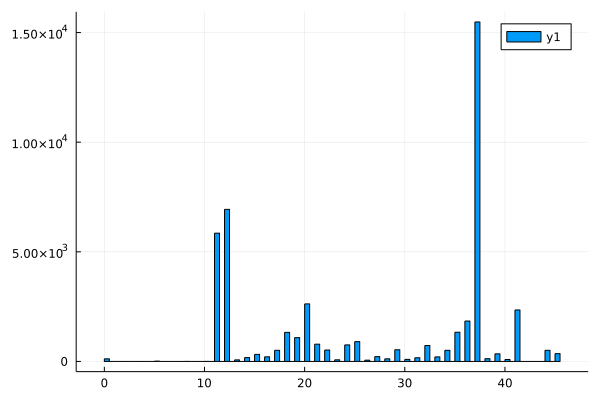

In [676]:
histogram(xold.MBQ_Mutect_2,bins=200)

In [694]:
# lazyarray(f, x) = LazyArray(Base.broadcasted(f, x))
@model function logreg(X,  y; predictors=size(X, 2))
    #priors
    α ~ Normal(0, 3)
    β ~ filldist(
        TDist(3),
#         Beta(1,1),
        predictors)

    #likelihood
#     for i in 1:predictors
#         y[i] ~ BernoulliLogit(α + LinearAlgebra.dot(X[i,:], β) ) # arraydist( LazyArray(@~ BernoulliLogit.(α .+ X * β) ) )
#     end
    y ~ arraydist(LazyArray(Base.broadcasted(x -> BernoulliLogit(x), α .+ X * β ) ))
end;


In [695]:
d = train; #vcat(train[findall(x->x,yb[train])],train[1:1425])
cols = ["gt_AF_Mutect","MPOS_Mutect","TLOD_Mutect","MBQ_Mutect_2","pon_pvalue_Mutect",
"gt_AD_ref_Mutect_std",
    "gt_AD_alt_Mutect_std"
]

7-element Vector{String}:
 "gt_AF_Mutect"
 "MPOS_Mutect"
 "TLOD_Mutect"
 "MBQ_Mutect_2"
 "pon_pvalue_Mutect"
 "gt_AD_ref_Mutect_std"
 "gt_AD_alt_Mutect_std"

In [696]:
sum(.~ yb[d])

1222

In [697]:
size(xb[d,cols])

(1289, 7)

In [698]:
# findall(x->x,yb[train])

In [699]:
# train[1:385]

In [700]:

# gmm_sampler = Gibbs(PG(100,:p5,:p7,:p10,:p11,:p12), HMC(0.05, 100, :intercept, :p1,:p2,:p3,:p4,:p6,:p8,:p9))

# Sample using HMC.
m = logreg(Matrix(xb[d,cols]), convert.(Float32,yb[d]) )

chain = sample(m, NUTS(), MCMCThreads(), 1000, 5, progress=true)
# chain = sample(m, gmm_sampler, MCMCThreads(), 100, 5, progress=true)
# chain = sample(m, NUTS(50,0.65), MCMCThreads(), 100, 2, progress=true)
# describe(chain)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/alexpanchot/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/alexpanchot/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/alexpanchot/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/alexpanchot/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/alexpanchot/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
Sampling (5 threads): 100%|█████████████████████████████| Time: 0:00:01


Chains MCMC chain (1000×20×5 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 5
Samples per chain = 1000
Wall duration     = 29.89 seconds
Compute duration  = 143.71 seconds
parameters        = α, β[1], β[2], β[3], β[4], β[5], β[6], β[7]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std   naive_se      mcse         ess      rhat   ⋯
      Symbol    Float64   Float64    Float64   Float64     Float64   Float64   ⋯

           α   -14.3754    1.8401     0.0260    0.0457   2127.8338    1.0045   ⋯
        β[1]     2.3299    1.1670     0.0165    0.0306   1720.9565    1.0014   ⋯
        β[2]    18.5996    4.2305     0.0598    0.0977   2101.7452    1.0018   ⋯
        β[3]     0.8321    0.9373     0.0133    0.0228   2107.2989    1.0013   ⋯
        β[4]    10.9212    5

In [701]:
# import Chain
# function logodds2prob(logodds::Float64)
#     return exp(logodds) / (1 + exp(logodds))
# end

# Chain.@chain quantile(chain) begin
#     DataFrame
#     select(_,
#         :parameters,
#         names(_, r"%") .=> ByRow(logodds2prob),
#         renamecols=false)
# end

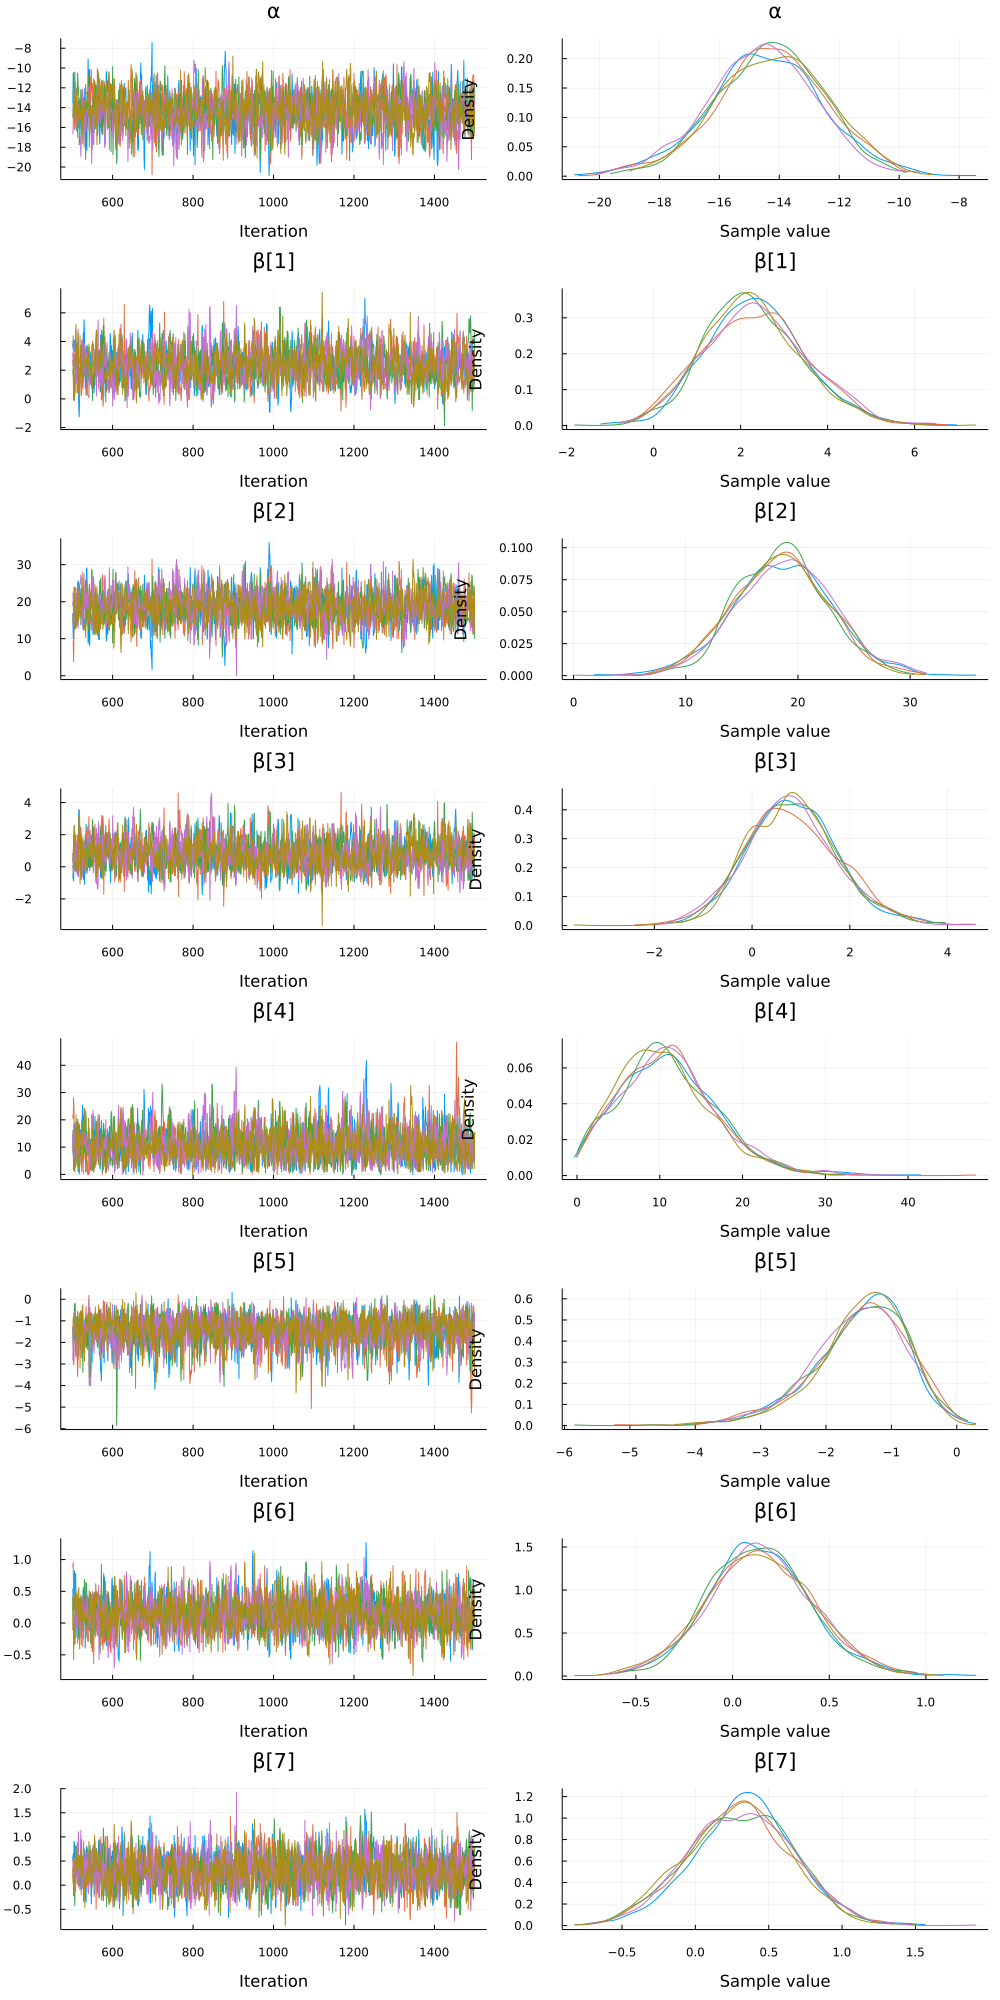

In [702]:
plot(chain[:,:,:])

In [703]:
# mean(chain["β[5]"])

In [704]:
# mode(round.(chain["β[5]"],digits=2))


In [705]:
# for beta_j in 1:size(xb,2)
#             if abs(mean(chain["β[$(beta_j)]"])) < 0.1
#                 println(beta_j)
#             end
# end

In [706]:
# @time abs(mean(chain["β[1]"]))

In [707]:
function prediction_turing(x, chain)
    # Pull the means from each parameter's sampled values in the chain.


    # Retrieve the number of rows.
    n = size(x,1)

    # Generate a vector to store our predictions.
    v = fill(mean(chain["α"]), n)

    # Calculate the logistic function for each element in the test set.
    

    for beta_j in 1:size(x,2)
        mm = mean(chain["β[$(beta_j)]"])
#         mm = mode(round.(chain["β[$(beta_j)]"],digits=4))
        if abs(mm) > 0.00001
            for i in 1:n
                v[i] += mm * x[i,beta_j] 
            end
        end
    end
        

    v = logistic.(v)
    return v
end;

In [708]:
@time ypred = prediction_turing(xb[test,cols],chain);

  0.299258 seconds (2.61 M allocations: 43.722 MiB, 73.36% gc time, 10.44% compilation time)


In [709]:
yhat2 = [i>.2 ? true : false for i in ypred];

In [710]:
MLJ.ConfusionMatrix()(yhat2,yb[test])

┌ Warning: The classes are un-ordered,
│ using: negative='false' and positive='true'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /Users/alexpanchot/.julia/packages/MLJBase/HZmTU/src/measures/confusion_matrix.jl:112


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │    false    │    true     │
├─────────────┼─────────────┼─────────────┤
│    false    │    28792    │     14      │
├─────────────┼─────────────┼─────────────┤
│    true     │    17239    │      5      │
└─────────────┴─────────────┴─────────────┘


In [537]:
# [print(i," ") for i in train]

In [538]:
asd=yhat2 .< yb[test];

In [539]:
sum(yb[test])

33

In [540]:
yb[test[asd]];

In [541]:
sample_key[test][asd]

6-element Vector{String}:
 "887041_1_100 4:106196951 A>G"
 "736399_1_100 4:106190822 C>A"
 "761809_1_100 2:25536827 G>A"
 "887041_1_100 2:198265526 A>G"
 "736399_1_100 4:106196829 T>G"
 "218281_1_100 4:106180823 C>T"

In [322]:
aa = DataFrame(x1=yhat2,x2=yb[test],sample_key=sample_key[test], vaf=untransform_log(untransform_standardizer(xb,stnd),10)[test,"gt_AF_Mutect"],
fp=xb[test,:FPpass])
# filter!(x-> x.x1==false && x.x2==true ,aa)
aafn=filter(x-> x.x1==true && x.x2==false && x.vaf > 0.001 && x.fp > 0.5,aa)
# aafn=filter(x-> x.x1==false && x.x2==true ,aa)
# # aatp=filter(x-> x.x1==true && x.x2==true ,aa)

# CSV.write("bmtreals1.csv",leftjoin(CSV.read("bmtreals.csv",DataFrame),
#         DataFrame(sample_key=aafn.sample_key, mutectFN = [1 for i in nrow(aafn)])
#         ,on=:sample_key))
# CSV.write("bmtreals1.csv",leftjoin(CSV.read("bmtreals1.csv",DataFrame),
#         DataFrame(sample_key=aatp.sample_key, mutectTP = [1 for i in nrow(aatp)])
#         ,on=:sample_key))

,x1,x2,sample_key,vaf,fp
,Bool,Bool,String,Float32,Float32
1,1,0,887041_1_5000 20:31023301 A>G,0.00473,1.0
2,1,0,736399_1_5000 20:31022542 A>G,0.003702,1.0
3,1,0,736399_1_100 20:31022542 A>G,0.003894,1.0
4,1,0,272341_1_100 20:31022545 C>T,0.00267,1.0
5,1,0,761809_1_5000 20:31023301 A>G,0.005531,1.0
6,1,0,761809_T 20:31022542 A>G,0.003957,1.0
7,1,0,272341_1_100 20:31022552 A>T,0.002667,1.0
8,1,0,218281_1_1000 20:31022542 A>G,0.003664,1.0
9,1,0,272341_1_5000 20:31023301 A>G,0.00549,1.0


In [398]:
sample_key[train][yb[train]]

34-element Vector{String}:
 "887041_1_100 20:31017746 CCAG>C"
 "D-1002 X:39923810 G>T"
 "218281_1_10 2:25457243 G>A"
 "761809_1_100 22:29085168 C>G"
 "218281_1_10 4:106193940 A>T"
 "887041_1_5000 20:30946591 CAGA>C"
 "272341_1_1000 20:31024787 T>C"
 "736399_1_5000 20:31022441 AG>A"
 "D-942 19:33792748 G>A"
 "736399_1_100 20:31022441 AG>A"
 "D-1002 X:39922132 A>C"
 "736399_1_10 4:106190822 C>A"
 "887041_1_1000 20:31023301 A>G"
 ⋮
 "D-1002 X:39909190 C>A"
 "D-1002 X:39922009 G>A"
 "736399_1_100 4:106196829 T>G"
 "809382_1_1000 20:31017746 CCAG>C"
 "887041_1_5000 17:74732995 C>G"
 "887041_1_100 4:106197574 GTC>G"
 "809382_1_5000 17:58678009 T>C"
 "D-1002 X:39916503 G>T"
 "887041_1_5000 2:198265526 A>G"
 "D-942 4:106157663 C>T"
 "218281_1_100 4:106180823 C>T"
 "809382_1_100 2:25464444 A>G"